<a id="title_ID"></a>
# JWST Pipeline Validation Testing Notebook: MIRI LRS Slit

## Spec2: Assign_wcs()
<span style="color:red"> **Instruments Affected**</span>: FGS, MIRI, NIRCam, NIRISS, NIRSpec 

### Table of Contents
<div style="text-align: left"> 

<br> [Imports](#imports_ID) <br> [Introduction](#intro_ID) <br> [Get Documentaion String for Markdown Blocks](#markdown_from_docs) <br> [Loading Data](#data_ID) <br> [Run JWST Pipeline](#pipeline_ID) <br> [Create Figure or Print Output](#residual_ID) <br> [About This Notebook](#about_ID) <br>

</div>

In [1]:
# Create a temporary directory to hold notebook output, and change the working directory to that directory.
from tempfile import TemporaryDirectory
import os
import shutil
data_dir = TemporaryDirectory()

# If you have files that are in the notebook's directory, but that the notebook will need to use while
# running, copy them into the temporary directory here.
#
# files = ['name_of_file']
# for file_name in files:
#     shutil.copy(file_name, os.path.join(data_dir.name, file_name))

os.chdir(data_dir.name)

<a id="imports_ID"></a>
# Imports
List the library imports and why they are relevant to this notebook.

* os, glob for general  OS operations
* numpy
* logging
* astropy.io for opening fits files
* astropy.utils for remote data retrieval
* inspect to get the docstring of our objects.
* IPython.display for printing markdown output
* jwst.datamodels for building model for JWST Pipeline
* jwst.module.PipelineStep is the pipeline step being tested
* matplotlib.pyplot to generate plot
* matplotlib.patches to plot a shape
* pysiaf for SIAF access
* miricoord for coordinate conversion tools
* gwcs for wcs tools

[Top of Page](#title_ID)

In [2]:
import inspect
import numpy as np
import glob
import os
import logging
from IPython.display import Markdown
from jwst.datamodels import RampModel, ImageModel, CubeModel
from jwst.pipeline import Detector1Pipeline, Spec2Pipeline
from jwst.assign_wcs import AssignWcsStep
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import astropy.io.fits as fits
import astropy.io.ascii as ascii
from astropy.table import Table, Column
from astropy.utils.data import download_file
from gwcs.wcstools import grid_from_bounding_box
from numpy.testing import assert_allclose

from pysiaf import Siaf
import miricoord.imager.mirim_tools as mt
import miricoord.lrs.toolversions.lrs_pipetools_cdp7 as tv
from miricoord.lrs.lrs_pipetools import xytov2v3lam

from ci_watson.artifactory_helpers import get_bigdata

%matplotlib inline


<a id="intro_ID"></a>
# Introduction


In this notebook we will test the assign_wcs step of Spec2Pipeline() for **LRS slit** observations.

Step description: https://jwst-pipeline.readthedocs.io/en/latest/jwst/assign_wcs/index.html#assign-wcs-step

Pipeline code: https://github.com/spacetelescope/jwst/tree/master/jwst/assign_wcs


### Calibration WG Requested Algorithm: 

https://outerspace.stsci.edu/display/JWSTCC/Vanilla+Spectral+GWCS+Information



[Top of Page](#title_ID)

<a id="data_ID"></a>
# Loading Data

We are using here a simulated LRS slit observation, generated with MIRISim v2.3.0 (as of Dec 2020). It is a simple along-slit-nodded observation of a point source (the input was modelled on the flux calibrator BD+60). LRS slit observations cover the full array. 


[Top of Page](#title_ID)

In [3]:
Slitfile1 = get_bigdata('jwst_validation_notebooks',
                                     'validation_data',
                                     'calwebb_spec2',
                                    'spec2_miri_test',
                                    'miri_lrs_slit_pt_nod1_v2.3.fits')
 
Slitfile2 = get_bigdata('jwst_validation_notebooks',
                                     'validation_data',
                                     'calwebb_spec2',
                                    'spec2_miri_test',
                                    'miri_lrs_slit_pt_nod2_v2.3.fits')

files = [Slitfile1, Slitfile2]

In [4]:
print(files)

['/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp8fb6ywxr/miri_lrs_slit_pt_nod1_v2.3.fits', '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp8fb6ywxr/miri_lrs_slit_pt_nod2_v2.3.fits']


<a id="pipeline_ID"></a>
# Run JWST Pipeline

First we run the data through the Detector1() pipeline to convert the raw counts into slopes. This should use the calwebb_detector1.cfg file. The output of this stage will then be run through the assign_wcs() step, which is part of the Spec2Pipeline. 

[Top of Page](#title_ID)

### CalDetector1

We first run the data through the Detector1 pipeline, ensuring to pass the calwebb_detector1.cfg configuration file. 

In [5]:
det1_out = []
nods = []
for ff in files:
    det1 = Detector1Pipeline.call(ff, save_results=True)
    if 'nod1' in ff:
        nodno = 'nod1'
    else:
        nodno = 'nod2'
    det1_out.append(det1)
    nods.append(nodno)

2021-08-20 14:23:09,531 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /grp/crds/cache/references/jwst/jwst_miri_pars-detector1pipeline_0001.asdf


2021-08-20 14:23:09,548 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2021-08-20 14:23:09,550 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2021-08-20 14:23:09,551 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2021-08-20 14:23:09,553 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2021-08-20 14:23:09,554 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2021-08-20 14:23:09,555 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2021-08-20 14:23:09,556 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2021-08-20 14:23:09,558 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2021-08-20 14:23:09,559 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2021-08-20 14:23:09,560 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2021-08-20 14:23:09,561 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2021-08-20 14:23:09,562 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2021-08-20 14:23:09,564 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2021-08-20 14:23:09,565 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2021-08-20 14:23:09,570 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2021-08-20 14:23:09,572 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2021-08-20 14:23:09,573 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2021-08-20 14:23:09,698 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp8fb6ywxr/miri_lrs_slit_pt_nod1_v2.3.fits',).


2021-08-20 14:23:09,708 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'saturation': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'outpu

2021-08-20 14:23:09,900 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'miri_lrs_slit_pt_nod1_v2.3.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2021-08-20 14:23:09,950 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/grp/crds/cache/references/jwst/jwst_miri_dark_0058.fits'.


2021-08-20 14:23:09,952 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits'.


2021-08-20 14:23:09,955 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/grp/crds/cache/references/jwst/jwst_miri_linearity_0024.fits'.


2021-08-20 14:23:09,957 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/grp/crds/cache/references/jwst/jwst_miri_mask_0028.fits'.


2021-08-20 14:23:09,959 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2021-08-20 14:23:09,960 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/grp/crds/cache/references/jwst/jwst_miri_readnoise_0057.fits'.


2021-08-20 14:23:09,962 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.


2021-08-20 14:23:09,963 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is '/grp/crds/cache/references/jwst/jwst_miri_reset_0047.fits'.


2021-08-20 14:23:09,965 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/grp/crds/cache/references/jwst/jwst_miri_rscd_0010.fits'.


2021-08-20 14:23:09,967 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/grp/crds/cache/references/jwst/jwst_miri_saturation_0026.fits'.


2021-08-20 14:23:09,969 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2021-08-20 14:23:09,970 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2021-08-20 14:23:09,971 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2021-08-20 14:23:09,972 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2021-08-20 14:23:10,277 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2021-08-20 14:23:10,279 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp8fb6ywxr'}


2021-08-20 14:23:10,441 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES=1 is a power of 2; correction not needed


2021-08-20 14:23:10,442 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2021-08-20 14:23:10,446 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2021-08-20 14:23:10,545 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2021-08-20 14:23:10,547 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp8fb6ywxr'}


2021-08-20 14:23:10,568 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /grp/crds/cache/references/jwst/jwst_miri_mask_0028.fits


2021-08-20 14:23:10,898 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2021-08-20 14:23:11,020 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2021-08-20 14:23:11,022 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp8fb6ywxr'}


2021-08-20 14:23:11,040 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /grp/crds/cache/references/jwst/jwst_miri_saturation_0026.fits


2021-08-20 14:23:11,386 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 saturated pixels


2021-08-20 14:23:11,399 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2021-08-20 14:23:11,404 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2021-08-20 14:23:11,516 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2021-08-20 14:23:11,518 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp8fb6ywxr'}


2021-08-20 14:23:11,518 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2021-08-20 14:23:11,520 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


2021-08-20 14:23:11,608 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2021-08-20 14:23:11,610 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp8fb6ywxr'}


2021-08-20 14:23:11,787 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2021-08-20 14:23:11,917 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2021-08-20 14:23:11,919 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp8fb6ywxr'}


2021-08-20 14:23:12,086 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2021-08-20 14:23:12,207 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2021-08-20 14:23:12,209 - stpipe.Detector1Pipeline.reset - INFO - Step reset parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp8fb6ywxr'}


2021-08-20 14:23:12,229 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file /grp/crds/cache/references/jwst/jwst_miri_reset_0047.fits


2021-08-20 14:23:13,562 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2021-08-20 14:23:13,696 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2021-08-20 14:23:13,698 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp8fb6ywxr'}


2021-08-20 14:23:13,717 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /grp/crds/cache/references/jwst/jwst_miri_linearity_0024.fits


2021-08-20 14:23:14,232 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2021-08-20 14:23:14,350 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2021-08-20 14:23:14,352 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp8fb6ywxr', 'type': 'baseline'}


2021-08-20 14:23:14,373 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /grp/crds/cache/references/jwst/jwst_miri_rscd_0010.fits


2021-08-20 14:23:14,576 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2021-08-20 14:23:14,697 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2021-08-20 14:23:14,699 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp8fb6ywxr', 'dark_output': None}


2021-08-20 14:23:14,719 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /grp/crds/cache/references/jwst/jwst_miri_dark_0058.fits


2021-08-20 14:23:18,427 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=2, ngroups=10, nframes=1, groupgap=0


2021-08-20 14:23:18,428 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=2, ngroups=200, nframes=1, groupgap=0


2021-08-20 14:23:19,474 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2021-08-20 14:23:19,837 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2021-08-20 14:23:19,839 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp8fb6ywxr', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


2021-08-20 14:23:19,848 - stpipe.Detector1Pipeline.refpix - INFO - use_side_ref_pixels = True


2021-08-20 14:23:19,849 - stpipe.Detector1Pipeline.refpix - INFO - odd_even_columns = True


2021-08-20 14:23:19,850 - stpipe.Detector1Pipeline.refpix - INFO - side_smoothing_length = 11


2021-08-20 14:23:19,851 - stpipe.Detector1Pipeline.refpix - INFO - side_gain = 1.000000


2021-08-20 14:23:19,852 - stpipe.Detector1Pipeline.refpix - INFO - odd_even_rows = True


2021-08-20 14:23:20,019 - stpipe.Detector1Pipeline.refpix - INFO - Subtracting initial read from each integration


2021-08-20 14:23:20,340 - stpipe.Detector1Pipeline.refpix - INFO - Adding initial read back in


2021-08-20 14:23:20,392 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2021-08-20 14:23:20,494 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2021-08-20 14:23:20,496 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp8fb6ywxr', 'rejection_threshold': 4.0, 'three_group_rejection_threshold': 6.0, 'four_group_rejection_threshold': 5.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 1000.0, 'min_jump_to_flag_neighbors': 10.0}


2021-08-20 14:23:20,505 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2021-08-20 14:23:20,517 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits


2021-08-20 14:23:20,544 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_miri_readnoise_0057.fits


2021-08-20 14:23:20,562 - stpipe.Detector1Pipeline.jump - INFO - Using 1 core for jump detection 


2021-08-20 14:23:20,783 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2021-08-20 14:23:21,267 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1:


2021-08-20 14:23:21,885 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 81556 pixels with at least one CR and at least four groups


2021-08-20 14:23:21,887 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2021-08-20 14:23:21,888 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2021-08-20 14:23:23,763 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2:


2021-08-20 14:23:24,378 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 12188 pixels with at least one CR and at least four groups


2021-08-20 14:23:24,379 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2021-08-20 14:23:24,380 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2021-08-20 14:23:24,737 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 3.94993 sec


2021-08-20 14:23:24,742 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 4.237223


2021-08-20 14:23:24,746 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2021-08-20 14:23:24,883 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2021-08-20 14:23:24,885 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp8fb6ywxr', 'int_name': '', 'save_opt': False, 'opt_name': '', 'maximum_cores': 'none'}


2021-08-20 14:23:24,919 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_miri_readnoise_0057.fits


2021-08-20 14:23:24,935 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits


2021-08-20 14:23:24,952 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols


2021-08-20 14:23:24,953 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2021-08-20 14:23:24,967 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2021-08-20 14:23:24,969 - stpipe.Detector1Pipeline.ramp_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2021-08-20 14:23:45,117 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 8


2021-08-20 14:23:45,123 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 2


2021-08-20 14:23:45,219 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2021-08-20 14:23:45,362 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2021-08-20 14:23:45,364 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp8fb6ywxr'}


2021-08-20 14:23:45,396 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2021-08-20 14:23:45,397 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2021-08-20 14:23:45,400 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2021-08-20 14:23:45,493 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(2, 1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2021-08-20 14:23:45,495 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp8fb6ywxr'}


2021-08-20 14:23:45,527 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2021-08-20 14:23:45,529 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2021-08-20 14:23:45,531 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2021-08-20 14:23:45,631 - stpipe.Detector1Pipeline - INFO - Saved model in miri_lrs_slit_pt_nod1_v2.3_rateints.fits


2021-08-20 14:23:45,633 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2021-08-20 14:23:45,695 - stpipe.Detector1Pipeline - INFO - Saved model in miri_lrs_slit_pt_nod1_v2.3_rate.fits


2021-08-20 14:23:45,697 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2021-08-20 14:23:45,994 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /grp/crds/cache/references/jwst/jwst_miri_pars-detector1pipeline_0001.asdf


2021-08-20 14:23:46,009 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2021-08-20 14:23:46,011 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2021-08-20 14:23:46,012 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2021-08-20 14:23:46,014 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2021-08-20 14:23:46,015 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2021-08-20 14:23:46,017 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2021-08-20 14:23:46,019 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2021-08-20 14:23:46,020 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2021-08-20 14:23:46,022 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2021-08-20 14:23:46,023 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2021-08-20 14:23:46,024 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2021-08-20 14:23:46,026 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2021-08-20 14:23:46,027 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2021-08-20 14:23:46,029 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2021-08-20 14:23:46,030 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2021-08-20 14:23:46,032 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2021-08-20 14:23:46,033 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2021-08-20 14:23:46,131 - stpipe - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stpipe/step.py:359: ResourceWarning: unclosed file <_io.FileIO name='/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp8fb6ywxr/miri_lrs_slit_pt_nod2_v2.3.fits' mode='rb' closefd=True>
  gc.collect()



2021-08-20 14:23:46,161 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp8fb6ywxr/miri_lrs_slit_pt_nod2_v2.3.fits',).


2021-08-20 14:23:46,170 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'saturation': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'outpu

2021-08-20 14:23:46,295 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'miri_lrs_slit_pt_nod2_v2.3.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2021-08-20 14:23:46,301 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/grp/crds/cache/references/jwst/jwst_miri_dark_0058.fits'.


2021-08-20 14:23:46,303 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits'.


2021-08-20 14:23:46,305 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/grp/crds/cache/references/jwst/jwst_miri_linearity_0024.fits'.


2021-08-20 14:23:46,306 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/grp/crds/cache/references/jwst/jwst_miri_mask_0028.fits'.


2021-08-20 14:23:46,307 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2021-08-20 14:23:46,307 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/grp/crds/cache/references/jwst/jwst_miri_readnoise_0057.fits'.


2021-08-20 14:23:46,309 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.


2021-08-20 14:23:46,309 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is '/grp/crds/cache/references/jwst/jwst_miri_reset_0047.fits'.


2021-08-20 14:23:46,311 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/grp/crds/cache/references/jwst/jwst_miri_rscd_0010.fits'.


2021-08-20 14:23:46,312 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/grp/crds/cache/references/jwst/jwst_miri_saturation_0026.fits'.


2021-08-20 14:23:46,313 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2021-08-20 14:23:46,314 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2021-08-20 14:23:46,314 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2021-08-20 14:23:46,315 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2021-08-20 14:23:46,581 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2021-08-20 14:23:46,582 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp8fb6ywxr'}


2021-08-20 14:23:46,668 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES=1 is a power of 2; correction not needed


2021-08-20 14:23:46,669 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2021-08-20 14:23:46,671 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2021-08-20 14:23:46,768 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2021-08-20 14:23:46,769 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp8fb6ywxr'}


2021-08-20 14:23:46,788 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /grp/crds/cache/references/jwst/jwst_miri_mask_0028.fits


2021-08-20 14:23:47,087 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2021-08-20 14:23:47,182 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2021-08-20 14:23:47,184 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp8fb6ywxr'}


2021-08-20 14:23:47,202 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /grp/crds/cache/references/jwst/jwst_miri_saturation_0026.fits


2021-08-20 14:23:47,452 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 saturated pixels


2021-08-20 14:23:47,466 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2021-08-20 14:23:47,471 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2021-08-20 14:23:47,582 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2021-08-20 14:23:47,584 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp8fb6ywxr'}


2021-08-20 14:23:47,585 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2021-08-20 14:23:47,586 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


2021-08-20 14:23:47,679 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2021-08-20 14:23:47,681 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp8fb6ywxr'}


2021-08-20 14:23:47,846 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2021-08-20 14:23:47,942 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2021-08-20 14:23:47,944 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp8fb6ywxr'}


2021-08-20 14:23:48,034 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2021-08-20 14:23:48,148 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2021-08-20 14:23:48,149 - stpipe.Detector1Pipeline.reset - INFO - Step reset parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp8fb6ywxr'}


2021-08-20 14:23:48,168 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file /grp/crds/cache/references/jwst/jwst_miri_reset_0047.fits


2021-08-20 14:23:48,564 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2021-08-20 14:23:48,681 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2021-08-20 14:23:48,683 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp8fb6ywxr'}


2021-08-20 14:23:48,702 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /grp/crds/cache/references/jwst/jwst_miri_linearity_0024.fits


2021-08-20 14:23:49,091 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2021-08-20 14:23:49,198 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2021-08-20 14:23:49,200 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp8fb6ywxr', 'type': 'baseline'}


2021-08-20 14:23:49,219 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /grp/crds/cache/references/jwst/jwst_miri_rscd_0010.fits


2021-08-20 14:23:49,417 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2021-08-20 14:23:49,513 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2021-08-20 14:23:49,515 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp8fb6ywxr', 'dark_output': None}


2021-08-20 14:23:49,534 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /grp/crds/cache/references/jwst/jwst_miri_dark_0058.fits


2021-08-20 14:23:51,244 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=2, ngroups=10, nframes=1, groupgap=0


2021-08-20 14:23:51,245 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=2, ngroups=200, nframes=1, groupgap=0


2021-08-20 14:23:52,023 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2021-08-20 14:23:52,362 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2021-08-20 14:23:52,364 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp8fb6ywxr', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


2021-08-20 14:23:52,374 - stpipe.Detector1Pipeline.refpix - INFO - use_side_ref_pixels = True


2021-08-20 14:23:52,375 - stpipe.Detector1Pipeline.refpix - INFO - odd_even_columns = True


2021-08-20 14:23:52,375 - stpipe.Detector1Pipeline.refpix - INFO - side_smoothing_length = 11


2021-08-20 14:23:52,376 - stpipe.Detector1Pipeline.refpix - INFO - side_gain = 1.000000


2021-08-20 14:23:52,376 - stpipe.Detector1Pipeline.refpix - INFO - odd_even_rows = True


2021-08-20 14:23:52,535 - stpipe.Detector1Pipeline.refpix - INFO - Subtracting initial read from each integration


2021-08-20 14:23:52,853 - stpipe.Detector1Pipeline.refpix - INFO - Adding initial read back in


2021-08-20 14:23:52,904 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2021-08-20 14:23:52,994 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2021-08-20 14:23:52,998 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp8fb6ywxr', 'rejection_threshold': 4.0, 'three_group_rejection_threshold': 6.0, 'four_group_rejection_threshold': 5.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 1000.0, 'min_jump_to_flag_neighbors': 10.0}


2021-08-20 14:23:53,014 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2021-08-20 14:23:53,028 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits


2021-08-20 14:23:53,057 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_miri_readnoise_0057.fits


2021-08-20 14:23:53,074 - stpipe.Detector1Pipeline.jump - INFO - Using 1 core for jump detection 


2021-08-20 14:23:53,222 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2021-08-20 14:23:53,685 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1:


2021-08-20 14:23:54,310 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 82114 pixels with at least one CR and at least four groups


2021-08-20 14:23:54,311 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2021-08-20 14:23:54,311 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2021-08-20 14:23:56,255 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2:


2021-08-20 14:23:56,844 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 12385 pixels with at least one CR and at least four groups


2021-08-20 14:23:56,845 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2021-08-20 14:23:56,846 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2021-08-20 14:23:57,209 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 3.98535 sec


2021-08-20 14:23:57,212 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 4.197068


2021-08-20 14:23:57,215 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2021-08-20 14:23:57,330 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2021-08-20 14:23:57,332 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp8fb6ywxr', 'int_name': '', 'save_opt': False, 'opt_name': '', 'maximum_cores': 'none'}


2021-08-20 14:23:57,362 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_miri_readnoise_0057.fits


2021-08-20 14:23:57,380 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits


2021-08-20 14:23:57,396 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols


2021-08-20 14:23:57,397 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2021-08-20 14:23:57,410 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2021-08-20 14:23:57,411 - stpipe.Detector1Pipeline.ramp_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2021-08-20 14:24:17,789 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 8


2021-08-20 14:24:17,791 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 2


2021-08-20 14:24:17,873 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2021-08-20 14:24:17,991 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2021-08-20 14:24:17,993 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp8fb6ywxr'}


2021-08-20 14:24:18,033 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2021-08-20 14:24:18,034 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2021-08-20 14:24:18,036 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2021-08-20 14:24:18,125 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(2, 1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2021-08-20 14:24:18,127 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp8fb6ywxr'}


2021-08-20 14:24:18,159 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2021-08-20 14:24:18,160 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2021-08-20 14:24:18,163 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2021-08-20 14:24:18,251 - stpipe.Detector1Pipeline - INFO - Saved model in miri_lrs_slit_pt_nod2_v2.3_rateints.fits


2021-08-20 14:24:18,253 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2021-08-20 14:24:18,313 - stpipe.Detector1Pipeline - INFO - Saved model in miri_lrs_slit_pt_nod2_v2.3_rate.fits


2021-08-20 14:24:18,314 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


### AssignWcs

The AssignWcs step should not change anything in the science data or error extension. It attaches the WCS information to the data, so that a location in detector pixels can be reconstructed to an RA, dec, wavelength in spatial and spectral space. 

In [6]:
awcs_out = []

for dd in det1_out:
    awcs = AssignWcsStep.call(dd,save_results=True) 
    awcs_out.append(awcs)

2021-08-20 14:24:18,332 - stpipe.AssignWcsStep - INFO - AssignWcsStep instance created.


2021-08-20 14:24:18,445 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep running with args (<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod1_v2.3_rate.fits>,).


2021-08-20 14:24:18,447 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2021-08-20 14:24:18,756 - stpipe.AssignWcsStep - INFO - Created a MIRI mir_lrs-fixedslit pipeline with references {'distortion': '/grp/crds/cache/references/jwst/jwst_miri_distortion_0028.asdf', 'filteroffset': None, 'specwcs': '/grp/crds/cache/references/jwst/jwst_miri_specwcs_0003.fits', 'regions': None, 'wavelengthrange': None, 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2021-08-20 14:24:18,824 - stpipe.AssignWcsStep - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/gwcs/utils.py:72: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indx = np.asarray(np.floor(np.asarray(value) + 0.5), dtype=np.int)



2021-08-20 14:24:18,830 - stpipe.AssignWcsStep - INFO - Update S_REGION to POLYGON ICRS  0.000379612 -0.000035778 0.000379612 0.000080412 359.999082432 0.000080412 359.999082432 -0.000035778


2021-08-20 14:24:18,831 - stpipe.AssignWcsStep - INFO - assign_wcs updated S_REGION to POLYGON ICRS  0.000379612 -0.000035778 0.000379612 0.000080412 359.999082432 0.000080412 359.999082432 -0.000035778


2021-08-20 14:24:18,831 - stpipe.AssignWcsStep - INFO - COMPLETED assign_wcs


2021-08-20 14:24:18,959 - stpipe.AssignWcsStep - INFO - Saved model in miri_lrs_slit_pt_nod1_v2.3_assignwcsstep.fits


2021-08-20 14:24:18,960 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep done


2021-08-20 14:24:18,969 - stpipe.AssignWcsStep - INFO - AssignWcsStep instance created.


2021-08-20 14:24:19,063 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep running with args (<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod2_v2.3_rate.fits>,).


2021-08-20 14:24:19,065 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2021-08-20 14:24:19,317 - stpipe.AssignWcsStep - INFO - Created a MIRI mir_lrs-fixedslit pipeline with references {'distortion': '/grp/crds/cache/references/jwst/jwst_miri_distortion_0028.asdf', 'filteroffset': None, 'specwcs': '/grp/crds/cache/references/jwst/jwst_miri_specwcs_0003.fits', 'regions': None, 'wavelengthrange': None, 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2021-08-20 14:24:19,372 - stpipe.AssignWcsStep - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/gwcs/utils.py:72: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indx = np.asarray(np.floor(np.asarray(value) + 0.5), dtype=np.int)



2021-08-20 14:24:19,377 - stpipe.AssignWcsStep - INFO - Update S_REGION to POLYGON ICRS  0.000903013 -0.000079284 0.000903013 0.000036907 359.999605833 0.000036907 359.999605833 -0.000079284


2021-08-20 14:24:19,378 - stpipe.AssignWcsStep - INFO - assign_wcs updated S_REGION to POLYGON ICRS  0.000903013 -0.000079284 0.000903013 0.000036907 359.999605833 0.000036907 359.999605833 -0.000079284


2021-08-20 14:24:19,379 - stpipe.AssignWcsStep - INFO - COMPLETED assign_wcs


2021-08-20 14:24:19,507 - stpipe.AssignWcsStep - INFO - Saved model in miri_lrs_slit_pt_nod2_v2.3_assignwcsstep.fits


2021-08-20 14:24:19,509 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep done


<a id="residual_ID"></a>
## Output checks and tests

We can use the output model to run the following checks:

* the SCI extension is unchanged from the step input (accept default tolerances for the np.allclose() function)
* we visualize the location of the bounding box.
* we use the wcs information assigned in the step to check the RA, dec, wavelength assignment at some reference locations. 

For LRS slit, the bounding box is defined from the wave/distortion reference file, as follows:

``bb_sub = ((np.floor(x0.min() + zero_point[0]) - 0.5, np.ceil(x1.max() + zero_point[0]) + 0.5),
                  (np.floor(y2.min() + zero_point[1]) - 0.5, np.ceil(y0.max() + zero_point[1]) + 0.5))``

where ``x0`` is the x-coordinate of the top-left corner, ``x1`` of the top-right corner, ``y0`` the y-coordinate of the top-left corner, ``y2`` of the bottom-right corner. ``zero_point`` is the slit centre coordiate as defined in the IMX and IMY header keywords. The 0.5 is to account for different pixel counting conventions.

[Top of Page](#title_ID)

In [7]:
# Do a numeric check between input and output
for (aa, dd, nn) in zip(awcs_out, det1_out, nodno):
    assert np.allclose(aa.data, dd.data, equal_nan=True), "Step input and output don't match for {}".format(nodno)

In [8]:
for aa, nn in zip(awcs_out, nods):

    bbox_w = aa.meta.wcs.bounding_box[0][1] - aa.meta.wcs.bounding_box[0][0]
    bbox_ht = aa.meta.wcs.bounding_box[1][1] - aa.meta.wcs.bounding_box[1][0]
    print('Model bbox ({1})= {0} '.format(aa.meta.wcs.bounding_box, nn))
    print('Model: Height x width of bounding box ({2})= {0} x {1} pixels'.format(bbox_ht, bbox_w, nn))
    
# Check that the bounding boxes are the same for both nods:
assert awcs_out[0].meta.wcs.bounding_box == awcs_out[1].meta.wcs.bounding_box, "Bounding box for nod positions don't match"

Model bbox (nod1)= ((302.5, 346.5), (6.5, 396.5)) 
Model: Height x width of bounding box (nod1)= 390.0 x 44.0 pixels
Model bbox (nod2)= ((302.5, 346.5), (6.5, 396.5)) 
Model: Height x width of bounding box (nod2)= 390.0 x 44.0 pixels


(1024, 1032)

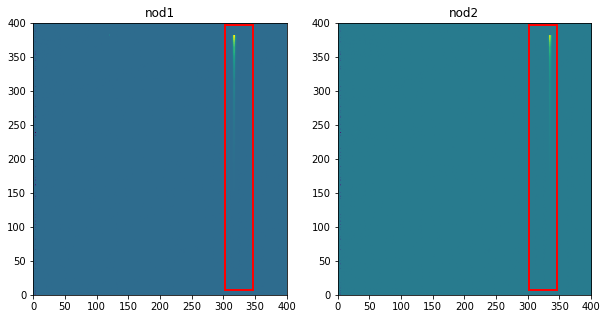

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=[10,5])

bbox0 = Rectangle((awcs_out[0].meta.wcs.bounding_box[0][0],awcs_out[0].meta.wcs.bounding_box[1][0]), bbox_w, bbox_ht, angle=0.0, ec='r', lw=2, fc='None')
bbox1 = Rectangle((awcs_out[1].meta.wcs.bounding_box[0][0],awcs_out[1].meta.wcs.bounding_box[1][0]), bbox_w, bbox_ht, angle=0.0, ec='r', lw=2, fc='None')

ax[0].imshow(awcs_out[0].data, origin='lower', interpolation='None', aspect='auto')
ax[0].add_patch(bbox0)
ax[0].set_xlim([0,400])
ax[0].set_ylim([0,400])
ax[0].set_title(nods[0])

ax[1].imshow(awcs_out[1].data, origin='lower', interpolation='None', aspect='auto')
ax[1].add_patch(bbox1)
ax[1].set_xlim([0,400])
ax[1].set_ylim([0,400])
ax[1].set_title(nods[1])

np.shape(awcs_out[0].data)

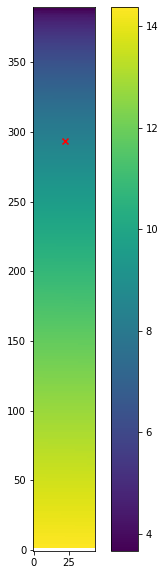

In [10]:
# Plot the wavelength solution based on the wcs information in the model
siaf = Siaf('MIRI')
ap = siaf['MIRIM_SLIT']
refpx_tel = ap.reference_point(to_frame='tel')
refpx_abs = mt.v2v3toxy(refpx_tel[0], refpx_tel[1], filter='F770W')
refpx = (refpx_abs[0] - awcs_out[0].meta.wcs.bounding_box[0][0], refpx_abs[1] - awcs_out[0].meta.wcs.bounding_box[1][0])
#print(refpx)

x,y = grid_from_bounding_box(awcs_out[0].meta.wcs.bounding_box)
ra, dec, lam = awcs_out[0].meta.wcs(x, y)

fig = plt.figure(figsize=[6,10])
imlam=plt.imshow(lam, origin='lower', interpolation='None')
cbar = fig.colorbar(imlam)
plt.scatter(refpx[0], refpx[1], marker='x', color='r')

Load the set of test coordinates from ``miricoord``. Then calculate the wavelength of these coordinates from the assign_wcs output models, and verify that they are close. If all the ``assert`` tests pass, this test is successful and complete.

In [11]:
xt,yt,v2t,v3t,lamt,stype=tv.testdata()

lamtest1 = np.zeros(3)
lamtest2 = np.zeros(3)
v2test1 = np.zeros(3)
v3test1 = np.zeros(3)
lt1 = np.zeros(3)

print('**** TEST SET ****')
print(' x       y     lam_truth  lamtest1  lamtest2  v2truth   v3truth  v2test   v3test')
for i in range (3):
    v2test1[i], v3test1[i], lt1[i] = xytov2v3lam(xt[0][i], yt[0][i], 'slit') 
    ra, dec, lamtest1[i] = awcs_out[0].meta.wcs(xt[0][i], yt[0][i])
    ra, dec, lamtest2[i] = awcs_out[1].meta.wcs(xt[0][i], yt[0][i])
    print('{0}  {1}   {2}    {3:.5f}    {4:.5f}  {5:.5f}   {6:.5f}   {7:.5f}   {8:.5f}'.format(xt[0][i], yt[0][i], lamt[0][i], lamtest1[i], lamtest2[i], v2t[0][i], v3t[0][i], v2test1[i], v3test1[i]))
    
    
    assert_allclose(lamt[0][i], lamtest1[i], atol=0.05)
    assert_allclose(lamt[0][i], lamtest2[i], atol=0.05)
    assert_allclose(v2t[0][i], v2test1[i], atol=0.05)
    assert_allclose(v3t[0][i], v3test1[i], atol=0.05)

**** TEST SET ****
 x       y     lam_truth  lamtest1  lamtest2  v2truth   v3truth  v2test   v3test
325.13  299.7   8.41039    8.41039    8.41039  -415.06900   -400.57590   -415.06905   -400.57592


325.13  29.7   14.05363    14.05363    14.05363  -415.19460   -400.56550   -415.19455   -400.56549
345.13  379.7   5.1474    5.14743    5.14743  -417.23700   -400.39580   -417.23700   -400.39585


<a id="about_ID"></a>
## About this Notebook
**Author:** Sarah Kendrew, ESA MIRI Instrument & Calibration Scientist, MIRI branch
<br>**Updated On:** 12/08/2020

[Top of Page](#title_ID)
<img style="float: right;" src="./stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="stsci_pri_combo_mark_horizonal_white_bkgd" width="200px"/> 